In [75]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
%run ./function.ipynb

### 1. Processing raw data 

In [33]:
# read data
data = pd.read_csv("ecommerce data.csv",encoding="ISO-8859-1",dtype = {"CustomerID":str, "InvoiceID":str})

print('Dataframe dimensions:', data.shape)

Dataframe dimensions: (541909, 8)


In [34]:
# convert column InvoiceDate to datetime
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values,0,0,1454,0,0,0,135080,0
null values(%),0,0,0.268311,0,0,0,24.9267,0


Text(0.5, 1.0, 'Ratio of missing values per columns')

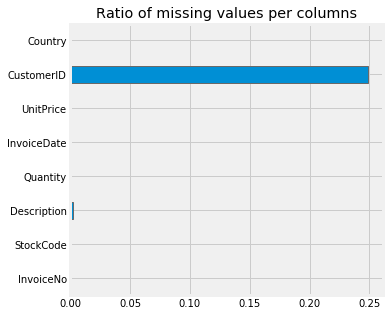

In [35]:
# basic infos and null values of this dataframe
tab_info = pd.DataFrame(data.dtypes).T.rename(index = {0:"column type"})
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename({0:"null values"}))
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename({0:"null values(%)"}))
display(tab_info)

plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

There are 24.9267% of entries not assigned to a specific customer, and it is impossible to impute CustomerID. Thus, we should delete those entries with null CustomerID.

In [36]:
# drop na in CustomerID column
data.dropna(axis = 0, subset = ["CustomerID"], inplace = True)
print("New dataframe dimensions:",data.shape)

tab_info = pd.DataFrame(data.dtypes).T.rename(index = {0:"column type"})
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename({0:"null values"}))
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename({0:"null values(%)"}))
display(tab_info)

New dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values,0,0,0,0,0,0,0,0
null values(%),0,0,0,0,0,0,0,0


In [37]:
# check the duplicates of all entries and delete them
print("Entries duplicates:{}".format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Entries duplicates:5225


### 2. Exploring the data
This dataframe contains 8 variables that correspond to: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

#### 2.1 Country

In [38]:
# group by ["CustomerID","InvoiceNo","Country"] before count orders
temp = data.loc[:,["CustomerID","InvoiceNo","Country"]].groupby(["CustomerID","InvoiceNo","Country"]).count()
temp = temp.reset_index(drop = False)
countries = pd.DataFrame(temp["Country"].value_counts()).reset_index(drop = False).rename(columns = {"index":"Name","Country":"Numbers"})

print("Orders came from {} countries. \n{}".format(len(countries), list(countries["Name"])))

Orders came from 37 countries. 
['United Kingdom', 'Germany', 'France', 'EIRE', 'Belgium', 'Spain', 'Netherlands', 'Switzerland', 'Portugal', 'Australia', 'Italy', 'Finland', 'Sweden', 'Norway', 'Channel Islands', 'Japan', 'Poland', 'Denmark', 'Cyprus', 'Austria', 'Malta', 'Singapore', 'Unspecified', 'Iceland', 'USA', 'Israel', 'Greece', 'Canada', 'European Community', 'Czech Republic', 'Lithuania', 'United Arab Emirates', 'Saudi Arabia', 'Bahrain', 'Lebanon', 'RSA', 'Brazil']


In [8]:
temp_data = dict(type='choropleth',locations = countries.iloc[:,0],
locationmode = 'country names', z = countries.iloc[:,1],
text = countries.iloc[:,0], colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Number of Orders Per Country',geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [temp_data], layout = layout)

iplot(choromap, validate=False)

The orders are mainly from United Kingdom.

#### 2.2 Customers and products

In [39]:
pd.DataFrame([{'Products': len(data["StockCode"].value_counts()),    
               'Transactions': len(data['InvoiceNo'].value_counts()),
               'Customers': len(data['CustomerID'].value_counts()) 
              }],index = ['quantity'])

,Products,Transactions,Customers
quantity,3684,22190,4372


In [40]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


Entries with the prefix C for the InvoiceNo variable indicate transactions have been canceled.

#### 2.2.1 Cancelling orders

First of all, I count the number of transactions corresponding to canceled orders:

In [41]:
nb_products_per_basket['Order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['Order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,Order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


#### 2.2.2 StockCode

Some values of the StockCode variable indicate a particular transaction (i.e. D for Discount). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [42]:
list_special_codes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [43]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, data[data['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


#### 2.2.3 Basket Price
I create a new variable that indicates the total price of every purchase:

In [44]:
# calculate the money of each line
data['TotalPrice'] = data['UnitPrice'] * data['Quantity'] 
data.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland,17.0
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland,13.2
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.0


In [45]:
# calcalate the top 10 customers who spent the highest money
pd.DataFrame(data.groupby(["CustomerID"])["TotalPrice"].sum()).sort_values("TotalPrice", ascending = False)[:10]

,TotalPrice
CustomerID,
14646,279489.02
18102,256438.49
17450,187322.17
14911,132458.73
12415,123725.45
14156,113214.59
17511,88125.38
16684,65892.08
13694,62690.54


Each entry of the dataframe shows the price for a single kind of product. Several entries belong to an order. Therefore, I collect all the purchases made during a single order and calculate the total price of each order.

In [46]:
# calculate the order price
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# calculate the average time
data['InvoiceDate_int'] = data['InvoiceDate'].astype('int64')
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
data.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# choose lines with basket_price>0
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12346,541431,77183.60,2011-01-18 10:01:00.000000000
2,12347,537626,711.79,2010-12-07 14:57:00.000001024
3,12347,542237,475.39,2011-01-26 14:29:59.999999744
4,12347,549222,636.25,2011-04-07 10:42:59.999999232
5,12347,556201,382.52,2011-06-09 13:01:00.000000256
6,12347,562032,584.91,2011-08-02 08:48:00.000000000


Visualize the distribution of order size

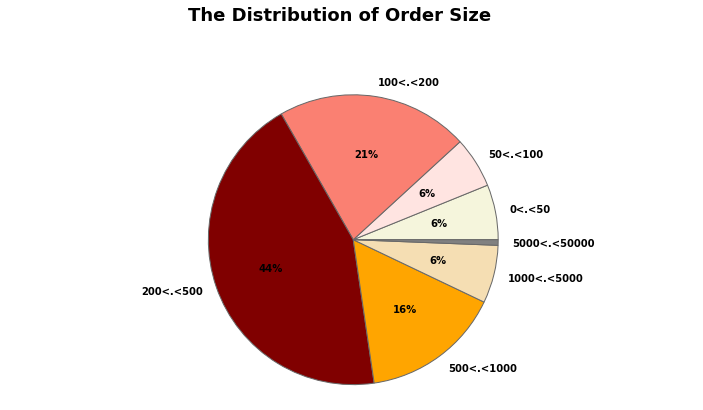

In [17]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['beige', 'mistyrose', 'salmon', 'maroon', 'orange', 'wheat','grey']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "The Distribution of Order Size", ha='center', fontsize = 18);

Seen from the pie chart, over 65% of orders have the price larger than 200 Euro.

___
### 3. Insight on product categories

Products are uniquely identified by the **StockCode** variable. **Description** describes the characteristics of each product.

#### 3.1 Products Description

Use keywords_inventory to extract information from the **Description** column

The first step of the analysis is to retrieve the list of products:

In [47]:
df_desc = pd.DataFrame(data['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [48]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_desc)

Number of keywords in variable 'Description': 1484


The function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used


In [49]:
# convert the `count_keywords` dictionary into a list and sort the keywords according to their occurences:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
    
list_products.sort(key = lambda x:x[1], reverse = True)

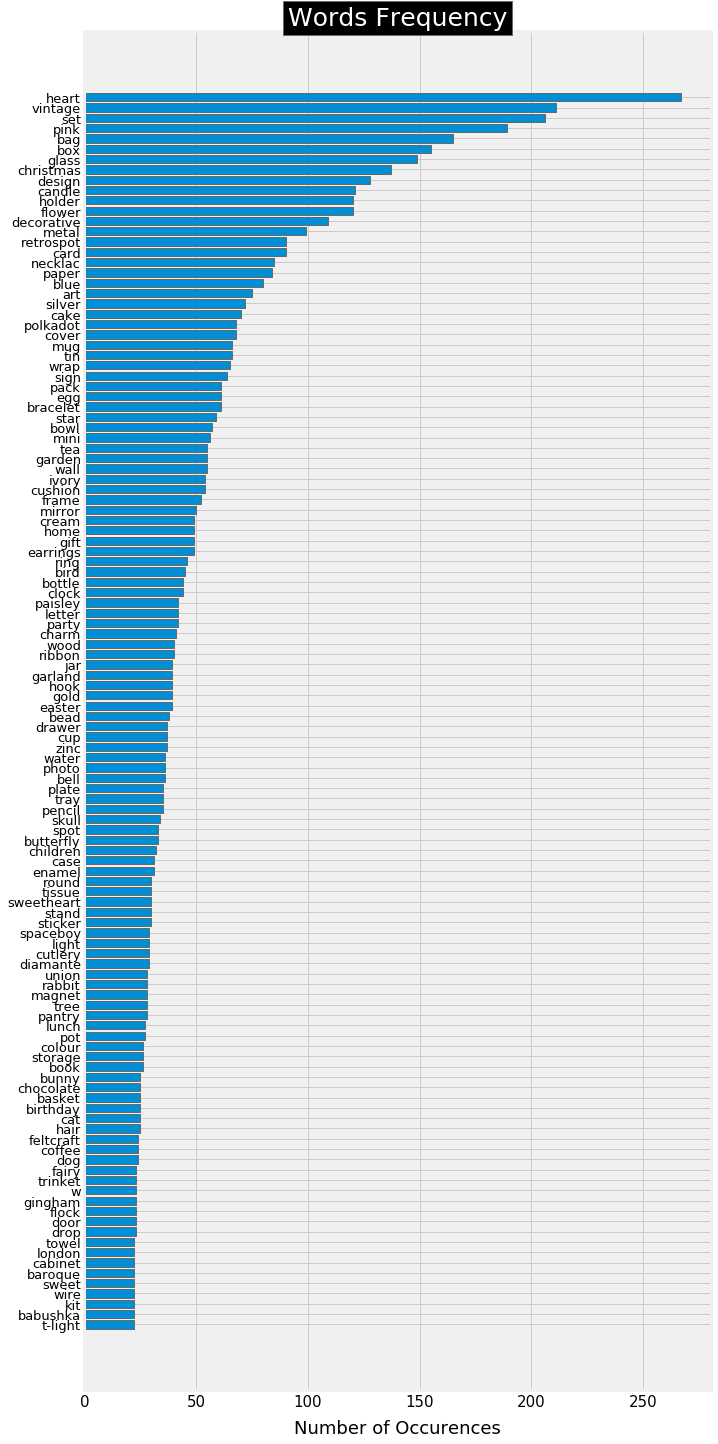

In [50]:
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(10, 25))
y_axis = [i[1] for i in list_products[:120]]
x_axis = [k for k,i in enumerate(list_products[:120])]
x_label = [i[0] for i in list_products[:120]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of Occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words Frequency",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

#### 3.2 Defining product categories 
The name list contains more than 1400 key words, and the most frequent used words appear in over 200 products. However, some extracted words do not carry information, such as colors. Therefore, we should discard these words before we do further analysis.

In [51]:
# filter the words
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 10: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse = True)
print('most:', len(list_products))

most: 240


#### 3.2.1 Data encoding

Use these keywords to create groups of product. 


In [52]:
desc = data['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), desc))
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,vanilla,animal,king,herb,english,jewellery,tutti,container,boudicca,pastel
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3894,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. 
In practice, introducing the price range will lead to more balanced groups in terms of element numbers.
Thus, we can add 6 extra columns to this matrix, which indicates the price range of the products:

In [53]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, review in enumerate(desc):
    price = data[data['Description'] == review]['UnitPrice'].mean()
    j = 0
    while price > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:

In [55]:
print("{:<10} {:<25} \n".format('range', 'num') )
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range      num                       

0<.<1       965                 
1<.<2       1013                
2<.<3       674                 
3<.<5       611                 
5<.<10      476                 
.>10        157                 


#### 3.2.2 Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). Note that the **kmeans** method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. 

In order to identify the number of clusters that best represents the data, I use the silhouette score:

In [59]:
matrix = X.as_matrix()
for n_clusters in range(3,11):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.0937179846554793
For n_clusters = 4 The average silhouette_score is : 0.11728773626134581
For n_clusters = 5 The average silhouette_score is : 0.13516240778923266
For n_clusters = 6 The average silhouette_score is : 0.13403958804016217
For n_clusters = 7 The average silhouette_score is : 0.13945532781703934
For n_clusters = 8 The average silhouette_score is : 0.1391756091975595
For n_clusters = 9 The average silhouette_score is : 0.1463003142864834
For n_clusters = 10 The average silhouette_score is : 0.11796239877662504


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of $ 0.1 \pm 0.05 $ will be obtained for all clusters with `n_clusters` $> $ 3 (we obtain slightly lower scores for the first cluster). 
In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [60]:
n_clusters = 9
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 9 The average silhouette_score is : 0.1375047066456857
For n_clusters = 9 The average silhouette_score is : 0.13341394874332313
For n_clusters = 9 The average silhouette_score is : 0.1043695882430606
For n_clusters = 9 The average silhouette_score is : 0.1358294220523682
For n_clusters = 9 The average silhouette_score is : 0.11849837040657464
For n_clusters = 9 The average silhouette_score is : 0.13600008901321023
For n_clusters = 9 The average silhouette_score is : 0.14378966893339373
For n_clusters = 9 The average silhouette_score is : 0.14286320774862174
For n_clusters = 9 The average silhouette_score is : 0.11070792207542048
For n_clusters = 9 The average silhouette_score is : 0.1268786697327283
For n_clusters = 9 The average silhouette_score is : 0.10006623951683487
For n_clusters = 9 The average silhouette_score is : 0.1452261161818223


#### 3.2.3  Characterizing the content of clusters
Print the number of elements in every class:

In [61]:
pd.Series(clusters).value_counts()

6    856
2    846
0    576
1    526
7    430
3    279
5    143
4    128
8    112
dtype: int64

* a / _Silhouette intra-cluster score_ 

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

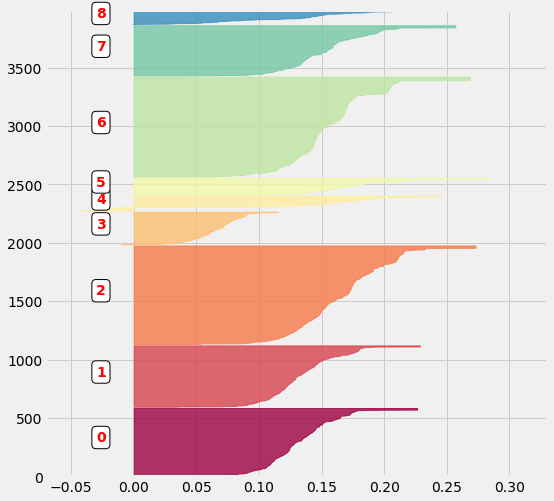

In [67]:
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

* b/ _Word Cloud_

Plot the word cloud of each group

In [81]:
ls_desc = pd.DataFrame(desc)
list_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    ls_cluster = ls_desc.loc[clusters == i]
    for word in list_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(ls_cluster.loc[:, 0].str.contains(word.upper()))

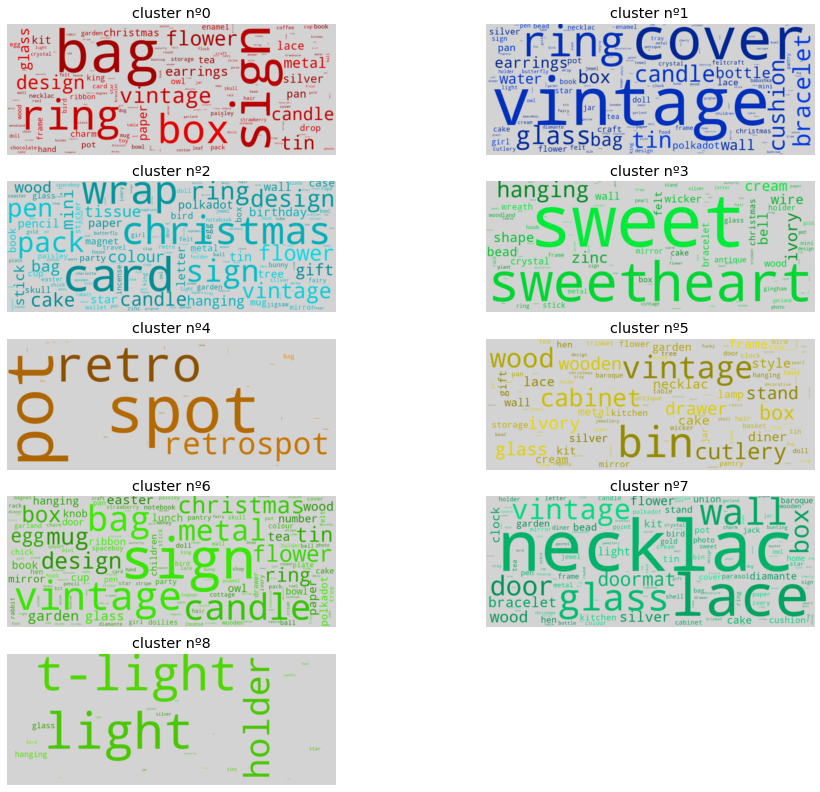

In [83]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 70, 200]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    list1 = []
    for key, value in list_cluster_occurences.items():
        list1.append([key, value])
    list1.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(list1, i+1)            

* c / _Principal Component Analysis_ 

In order to ensure that these clusters are truly distinct, I look at their composition. Given that the dimension is very high, we need to use PCA method to decrease the dimension.

In [84]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

Plot the explained variance graph to determine the number of components.

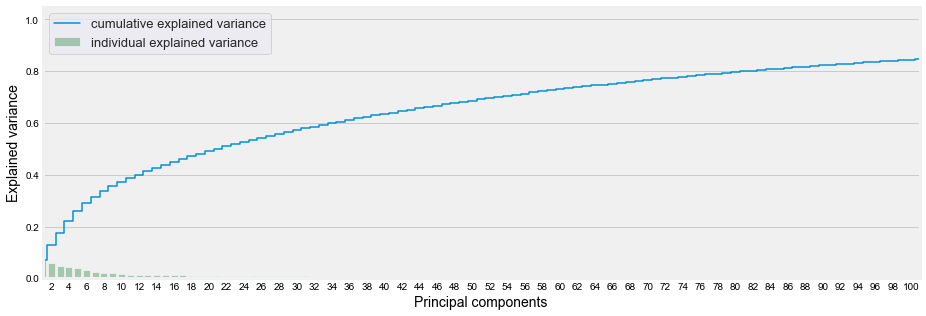

In [85]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

According to the explained variance plot, we need more than 80 components to explain 80% variance.I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [86]:
pca = PCA(n_components=82)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

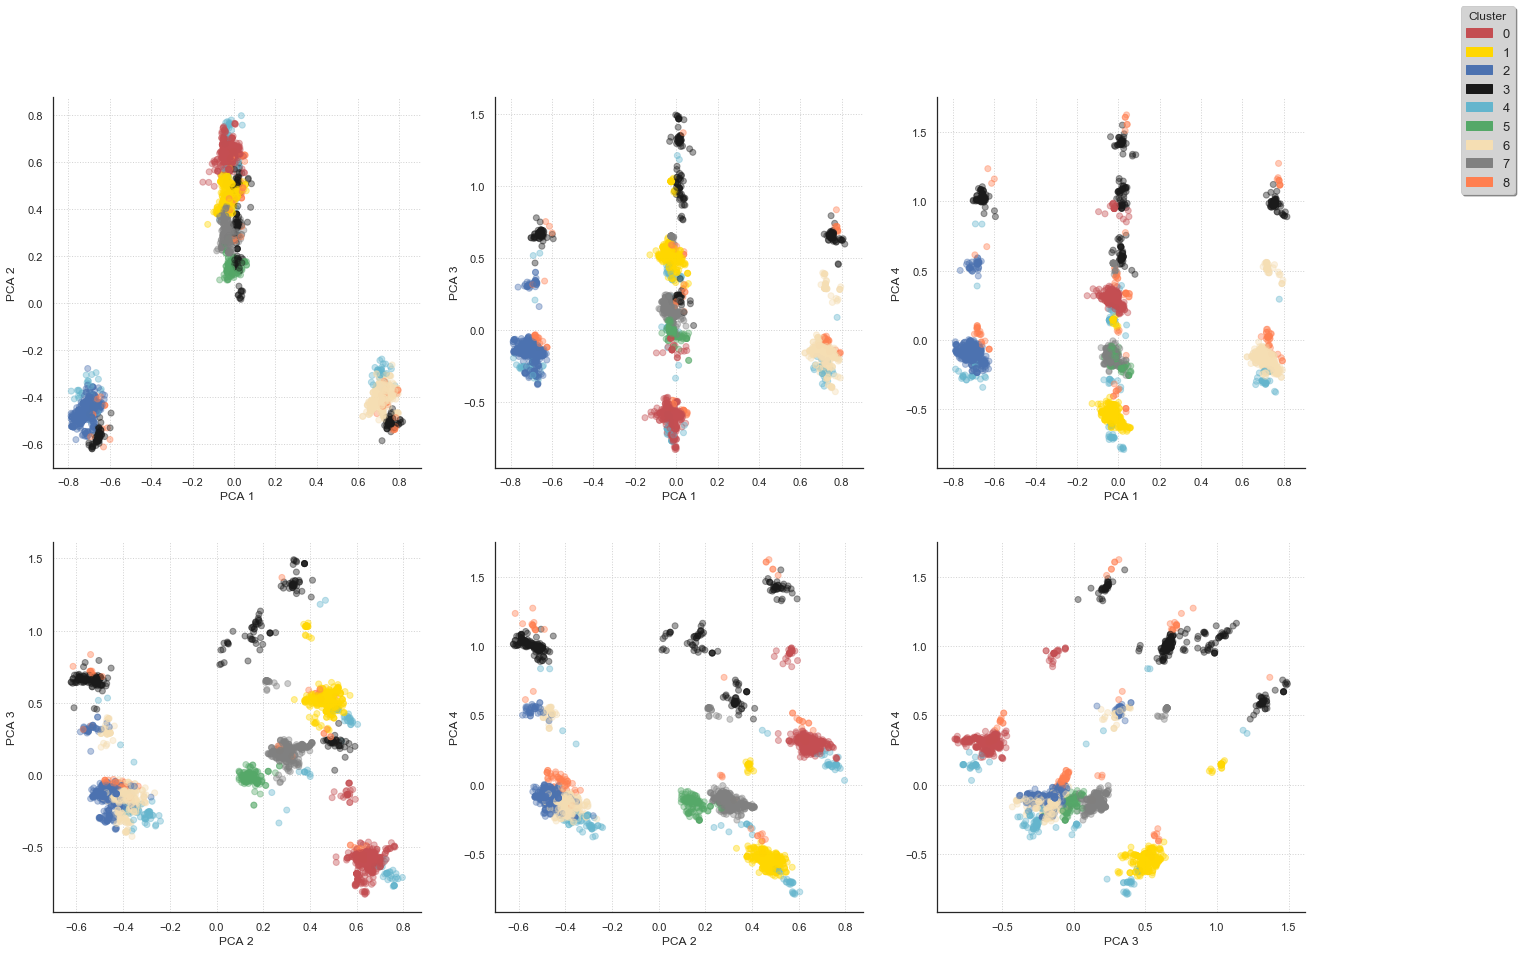

In [90]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g', 6:"wheat", 7:"grey",8:"coral"}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (20,15))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
comp_handler = []
for i in range(9):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()